# Tests for `aqua.stats`

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import aqua.manager
import aqua.stats

## `HiveManager` setup
Create a `HiveManager` to help manage the test dataset

In [2]:
## Set up the filename parser for managing our data

# Key is the label used in the file; value is the label to use in extracted data
condition_labels = {
    'condition1': 'C1',
    'condition2': 'C2'
}

# Specifies how to interpret each part of the filenames in the hive
filename_spec = [
    ('date', 'date', '%Y%m%d'),
    ('raw', 'mouse'),
    ('number', 'slice'),
    ('number', 'fov'),
    ('switch', 'condition', condition_labels),
    ('suffix', 'cell-events-marked')
]

parser = aqua.manager.get_standard_filename_parser( filename_spec )

## Set up the HiveManager

manager = aqua.manager.HiveManager( 'data',
                                    parser = parser )

## Dataset postprocessors

# In this hive, each FOV has multiple corresponding datasets
# This labels each dataset with a unique ID for each FOV
# (Each FOV is defined as a unique combination of ('mouse', 'slice', and 'fov'))
manager.add_dataset_postprocessor( 'fov_global',
                                   aqua.manager.get_coreg_postprocessor( ['mouse', 'slice', 'fov'] ) )

# Label each dataset with the proper orientation as specified in a YAML file
left_right_labels = aqua.manager.load_labels( os.path.join( 'data', 'labels.yaml' ),
                                              key = 'left_right' )
manager.add_dataset_postprocessor( 'left_right',
                                   aqua.manager.get_label_postprocessor( left_right_labels ) )

## Event postprocessors

# Add postprocessors that takes directional marks and aligns them to 'lateral' and 'medial'
manager.add_laterality_postprocessors()

# In this dataset there are multiple recordings in the same FOV; this creates a coregistered
# cell identifier 'cell_coreg' that is the same for cells in the same FOV (same 'fov_global')
# but in different datasets (different 'dataset_id')
manager.add_event_postprocessor( 'cell_coreg',
                                 aqua.manager.get_coreg_postprocessor( ['fov_global', 'cell'] ),
                                 for_all = True )
manager.add_raster_postprocessor( 'cell_coreg',
                                  aqua.manager.get_coreg_postprocessor( ['fov_global', 'cell'] ),
                                  for_all = True )

In [3]:
manager.datasets

,filename,date,mouse,slice,fov,condition,dataset_id,fov_global,left_right
0,20200810_mouse1_slice1_fov1_condition1_cell-ev...,2020-08-10,mouse1,1,1,C1,1,1,LM
1,20200810_mouse1_slice1_fov1_condition2_cell-ev...,2020-08-10,mouse1,1,1,C2,2,1,LM
2,20200810_mouse1_slice1_fov2_condition1_cell-ev...,2020-08-10,mouse1,1,2,C1,3,2,LM
3,20200810_mouse1_slice1_fov2_condition2_cell-ev...,2020-08-10,mouse1,1,2,C2,4,2,LM


## Test `ramp_effects`

In [4]:
raster_dataset_keys = [
    'condition',
    'dataset_id',
    'fov_global',
    'left_right'
]

headers, all_rasters = manager.all_rasters( dataset_keys = raster_dataset_keys,
                                            verbose = True )

Loading 20200810_mouse1_slice1_fov2_condition2_cell-events-marked.mat...: 100%|██████████| 4/4 [00:00<00:00, 19.50it/s]


In [5]:
all_rasters

,cell,event_count,center_time,center_frame,condition,dataset_id,fov_global,left_right,cell_global,cell_coreg
0,1,0,0.000000,0,C1,1,1,LM,1,1
1,1,0,0.703641,1,C1,1,1,LM,1,1
2,1,0,1.407281,2,C1,1,1,LM,1,1
3,1,1,2.110922,3,C1,1,1,LM,1,1
4,1,0,2.814562,4,C1,1,1,LM,1,1
...,...,...,...,...,...,...,...,...,...,...
11890,9,0,294.825160,419,C2,4,2,LM,28,14
11891,9,0,295.528800,420,C2,4,2,LM,28,14
11892,9,0,296.232440,421,C2,4,2,LM,28,14
11893,9,0,296.936080,422,C2,4,2,LM,28,14


In [6]:
ramp_window = [0., 140.]
ramp_effects = aqua.stats.ramp_effects( all_rasters, ramp_window,
                                        verbose = True )

100%|██████████| 28/28 [00:00<00:00, 96.72it/s]


In [7]:
ramp_effects

,cell_global,slope,p,slope_low,slope_high,effect
0,1,4.596427e-03,0.111265,-0.001060,0.010253,0
1,2,1.528793e-03,0.653170,-0.005139,0.008197,0
2,3,-1.420953e-03,0.727068,-0.009400,0.006558,0
3,4,1.854925e-03,0.623542,-0.005552,0.009262,0
4,5,3.999232e-03,0.202979,-0.002158,0.010156,0
5,6,7.093842e-03,0.011271,0.001607,0.012580,+
6,7,7.014281e-03,0.026767,0.000807,0.013221,+
7,8,-3.604048e-03,0.287441,-0.010245,0.003036,0
8,9,4.351240e-03,0.227298,-0.002712,0.011415,0
9,10,3.049959e-03,0.318761,-0.002946,0.009046,0


## Test `event_pca`

In [8]:
headers, all_events = manager.all_events( verbose = True )

Loading 20200810_mouse1_slice1_fov2_condition2_cell-events-marked.mat...: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


In [9]:
all_events

,start_frame,start_time,cell,mark_area,mark_circMetric,mark_decayTau,mark_dffMax,mark_dffMax2,mark_fall91,mark_nOccurSameLoc,...,mark_propShrinkRight_log,mark_propGrowLateral_log,mark_propGrowMedial_log,mark_propShrinkLateral_log,mark_propShrinkMedial_log,mark_rise19_log,mark_width11_log,mark_width55_log,cell_global,cell_coreg
0,228,160.430049,3,136.617717,6.849099,17.912407,6.176897,6.401530,21.109217,20.0,...,0.207575,-0.191983,0.396366,-0.096620,0.207575,0.847351,1.449411,0.888744,3,3
1,83,58.402167,1,155.719282,9.846423,1.396005,5.178956,5.403514,2.814562,48.0,...,-1.437999,-0.416897,-0.944524,-0.934847,-1.437999,0.449411,0.801593,0.625502,1,1
2,217,152.690002,3,73.084250,10.508848,1.308271,5.613347,5.680598,2.814562,19.0,...,-0.931614,-0.139059,-0.872086,-0.674855,-0.931614,0.148381,0.625502,0.324472,3,3
3,361,254.014244,5,21.177822,3.605072,2.233971,5.264596,5.451203,4.925484,9.0,...,-1.265478,NaN,-1.366936,-0.876242,-1.265478,0.324472,0.847351,0.546321,5,5
4,108,75.993181,5,7.474526,2.144421,1.227130,3.783576,3.967102,2.110922,3.0,...,NaN,NaN,NaN,NaN,NaN,-0.152649,0.449411,0.324472,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,89,62.623960,8,7.059273,0.864276,0.238465,6.166556,5.454804,0.703640,1.0,...,NaN,NaN,-1.115124,NaN,NaN,-0.152649,0.148381,0.148381,27,13
2662,160,112.582400,2,7.889776,1.514042,0.437996,8.813004,8.030525,2.110920,3.0,...,NaN,NaN,NaN,NaN,NaN,0.148381,0.546321,0.148381,21,7
2663,165,116.100600,4,14.949049,1.574417,0.506117,3.298952,3.154374,1.407280,2.0,...,NaN,NaN,0.482571,NaN,NaN,0.148381,0.449411,0.148381,23,9
2664,388,273.012320,4,5.813519,1.528797,0.719088,11.328653,9.077250,2.814560,8.0,...,NaN,NaN,NaN,NaN,NaN,-0.152649,0.546321,0.324472,23,9


In [10]:
loadings, frac_variance, scores = aqua.stats.event_pca( all_events,
                                                        whiten = True )

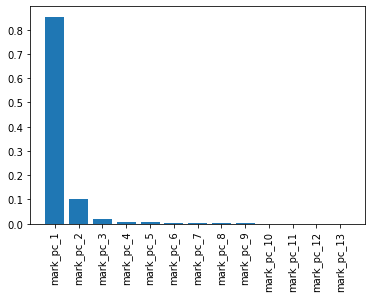

In [15]:
plt.bar( np.arange( frac_variance.shape[0] ), frac_variance )
plt.xticks( np.arange( frac_variance.shape[0] ), frac_variance.index, rotation = 90 )
plt.show()

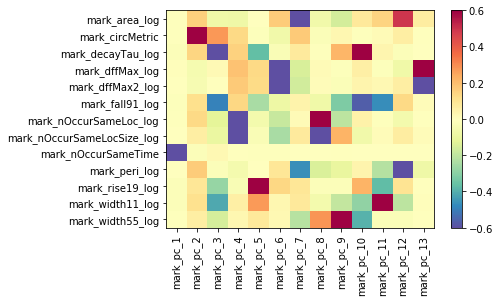

In [14]:
plt.imshow( loadings.T, aspect = 'auto', interpolation = 'none' )
plt.colorbar()
plt.clim( -0.6, 0.6 )
plt.set_cmap( 'Spectral_r' )
plt.yticks( np.arange( loadings.shape[1] ), loadings.columns )
plt.xticks( np.arange( loadings.shape[0] ), loadings.index, rotation = 90 )
plt.show()

In [18]:
all_events_merged = pd.merge( all_events, scores, left_index = True, right_index = True )

In [38]:
all_events_merged

,start_frame,start_time,cell,mark_area,mark_circMetric,mark_decayTau,mark_dffMax,mark_dffMax2,mark_fall91,mark_nOccurSameLoc,...,mark_pc_4,mark_pc_5,mark_pc_6,mark_pc_7,mark_pc_8,mark_pc_9,mark_pc_10,mark_pc_11,mark_pc_12,mark_pc_13
0,228,160.430049,3,136.617717,6.849099,17.912407,6.176897,6.401530,21.109217,20.0,...,2.160831,0.088252,-1.164604,-2.402565,1.761752,0.075517,0.546969,0.522676,2.724366,0.493353
1,83,58.402167,1,155.719282,9.846423,1.396005,5.178956,5.403514,2.814562,48.0,...,2.122712,0.265890,-1.275514,-0.947292,4.730423,-0.885684,0.846173,1.939277,5.102462,0.126191
2,217,152.690002,3,73.084250,10.508848,1.308271,5.613347,5.680598,2.814562,19.0,...,2.582170,-0.736897,-2.017465,1.578991,1.079818,-0.752162,0.932733,1.581978,6.458564,0.094661
3,361,254.014244,5,21.177822,3.605072,2.233971,5.264596,5.451203,4.925484,9.0,...,1.085470,-0.198744,-0.538020,-1.185342,1.360386,0.042379,-0.430437,-0.519222,-0.723429,-0.574162
4,108,75.993181,5,7.474526,2.144421,1.227130,3.783576,3.967102,2.110922,3.0,...,1.095117,-1.257453,0.293305,0.068541,-0.307718,0.967306,0.290553,0.147471,-1.275954,-1.139308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,89,62.623960,8,7.059273,0.864276,0.238465,6.166556,5.454804,0.703640,1.0,...,1.698305,-0.093115,0.344356,-1.295215,-0.824028,0.331726,0.283998,0.017901,0.957005,0.226497
2662,160,112.582400,2,7.889776,1.514042,0.437996,8.813004,8.030525,2.110920,3.0,...,0.688486,0.449722,-1.173134,-0.736057,-1.310525,-0.994895,-1.208191,-0.756828,0.044200,0.095625
2663,165,116.100600,4,14.949049,1.574417,0.506117,3.298952,3.154374,1.407280,2.0,...,1.339270,0.098833,1.583331,-1.807839,-0.237369,-1.190575,0.651238,-0.468238,-0.063906,0.038236
2664,388,273.012320,4,5.813519,1.528797,0.719088,11.328653,9.077250,2.814560,8.0,...,-0.107216,-0.957484,-2.544630,-0.265203,0.151585,0.139670,-2.003887,0.303192,-1.192995,1.201081


## Test `RateFunction`s

Compute kernel rates and bootstrap errors for each cell in each dataset

In [8]:
def plot_rate( ax, events, r, t,
               low = None,
               high = None,
               edge = None,
               color = 'k',
               label = None,
               y_events = -0.1 ):
    
    ts = np.array( events )
    ys = y_events * np.ones( ts.shape )
    ax.plot( ts, ys, f'{color}.', markersize = 1 )

    ax.plot( t, r, f'{color}-', label = label )
    if low is not None and high is not None:
        ax.fill_between( t, high, low, color = f'{color}', alpha = 0.2 )
        
    yl = ax.get_ylim()
    
    t_min = np.min( t )
    t_max = np.max( t )
    
    if edge is not None:
        ax.fill_between( np.array( [t_min, t_min + edge] ), yl[0], yl[1], color = 'c', alpha = 0.1 )
        ax.fill_between( np.array( [t_max, t_max - edge] ), yl[0], yl[1], color = 'c', alpha = 0.1 )

    ax.set_ylim( yl )
    
    xl = [t_min + edge, t_max - edge]
    ax.plot( xl, 0. * np.array( [1, 1] ), 'k-', linewidth = 1 )
    ax.set_xlim( xl )

    ax.set_xlabel( 'Time (s)' )
    ax.set_ylabel( 'Event rate (Hz)' )
    
    ax.set_title( f'Cell {i_cell + 1}' )

Plot individual fits

Dataset: 20200810_mouse1_slice1_fov1_condition1_cell-events-marked.mat


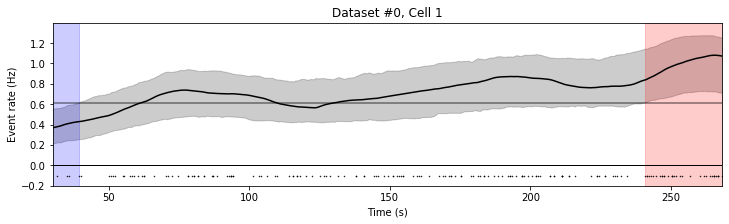

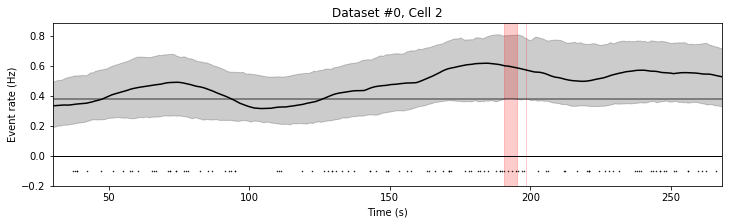

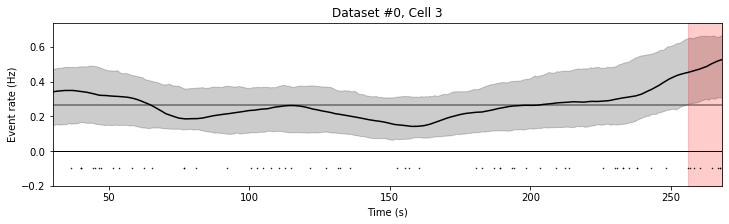

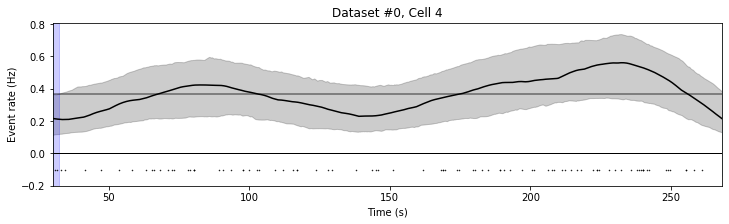

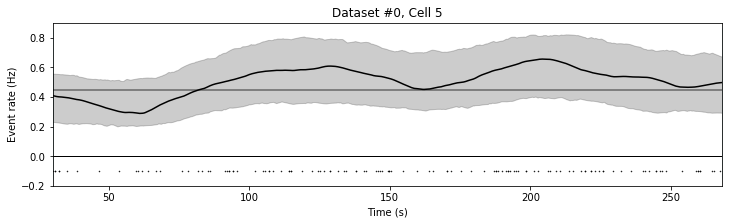

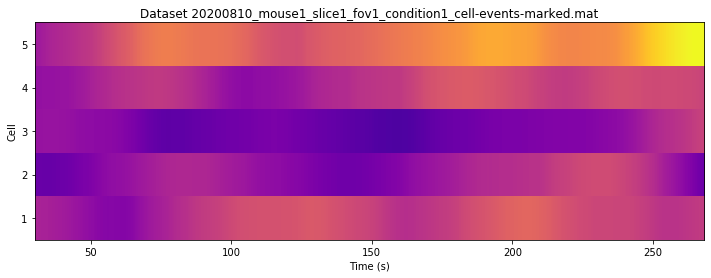

Dataset: 20200810_mouse1_slice1_fov1_condition2_cell-events-marked.mat


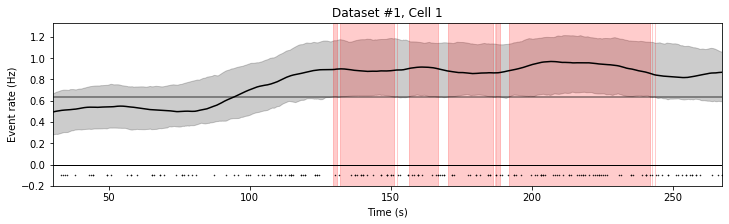

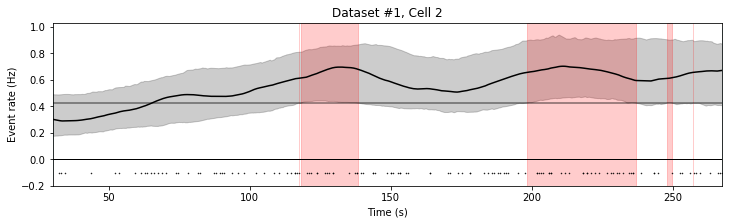

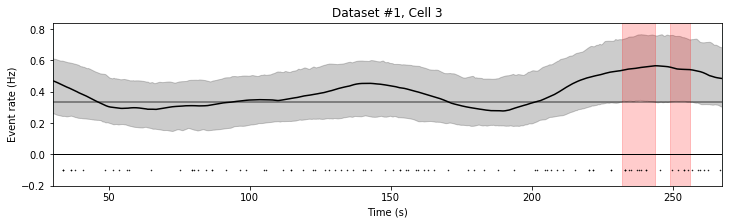

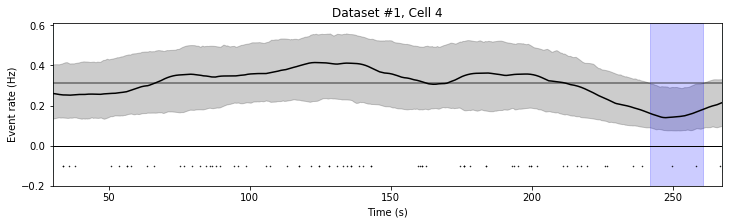

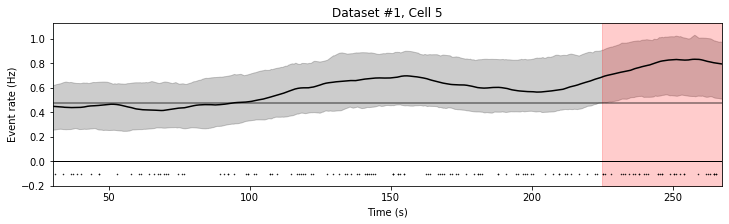

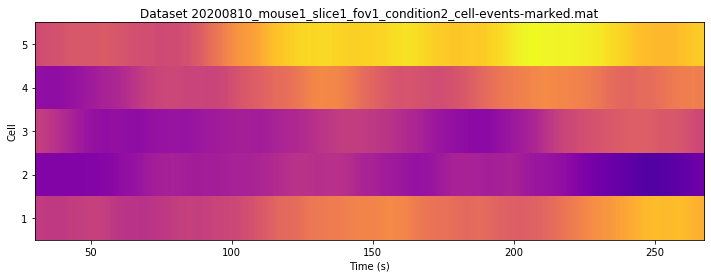

Dataset: 20200810_mouse1_slice1_fov2_condition1_cell-events-marked.mat


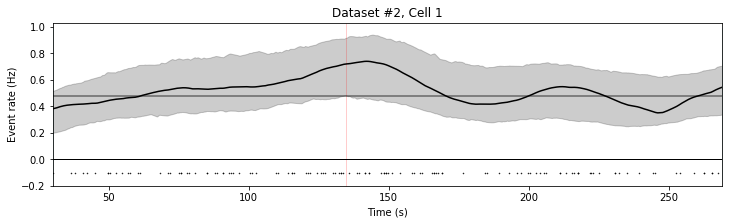

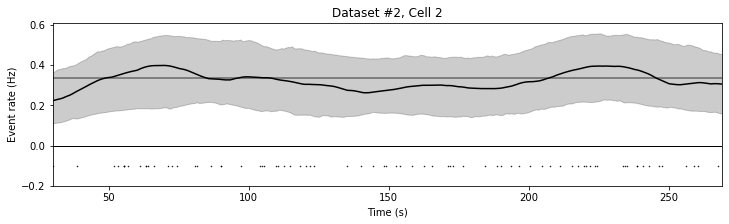

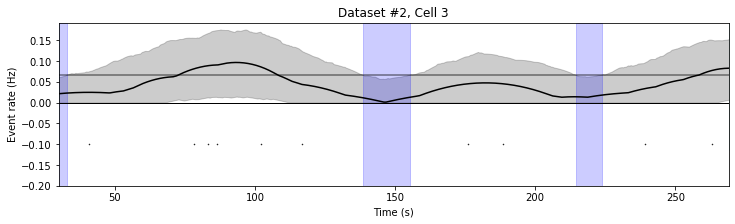

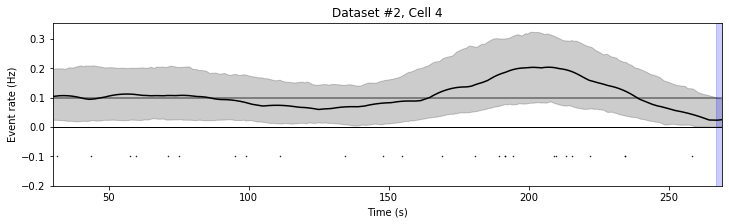

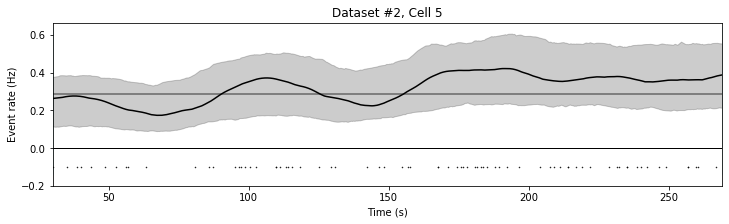

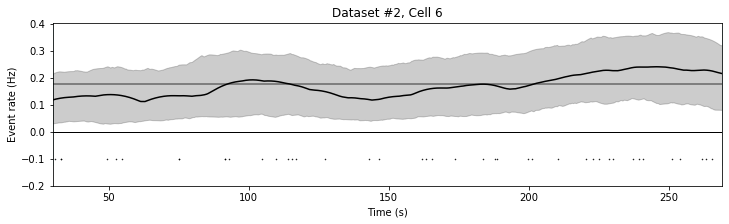

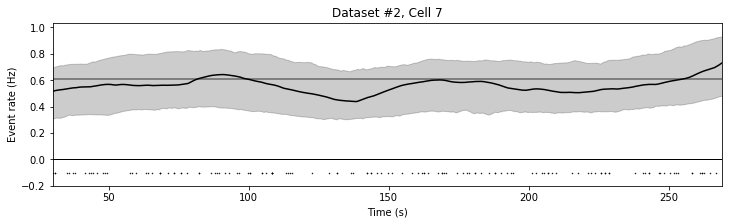

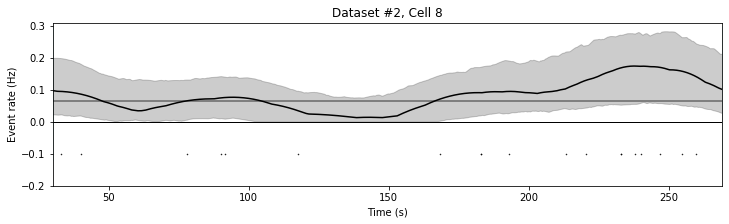

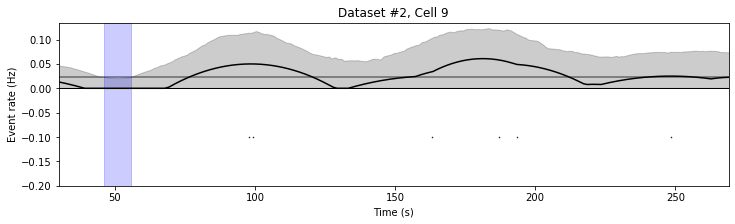

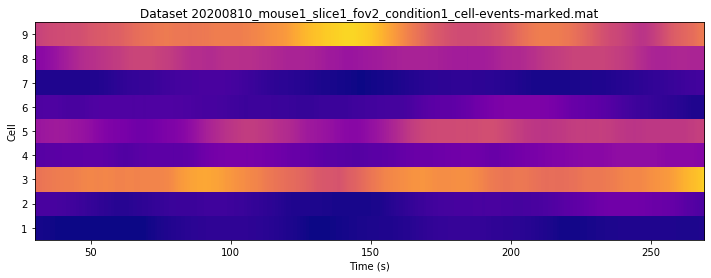

Dataset: 20200810_mouse1_slice1_fov2_condition2_cell-events-marked.mat


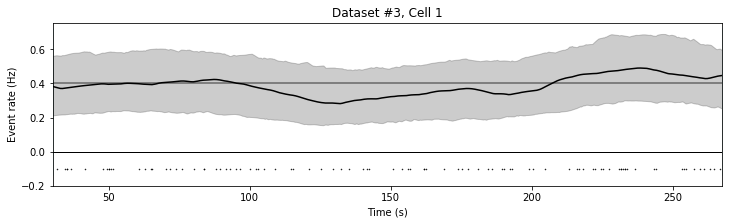

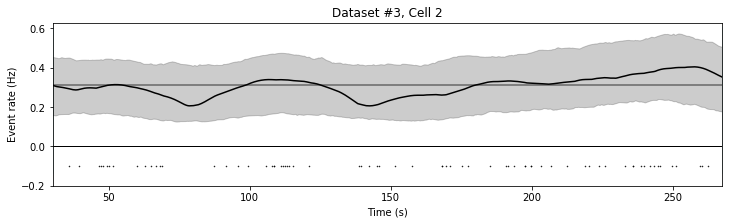

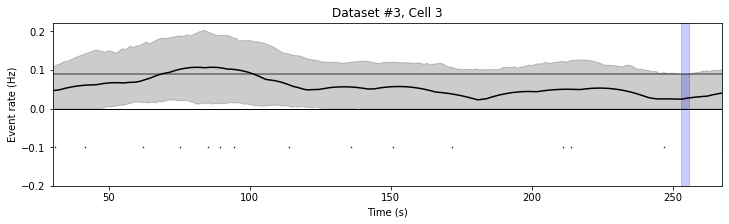

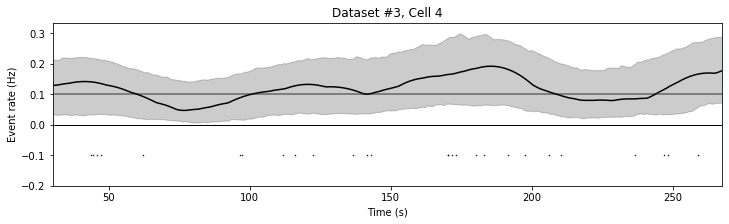

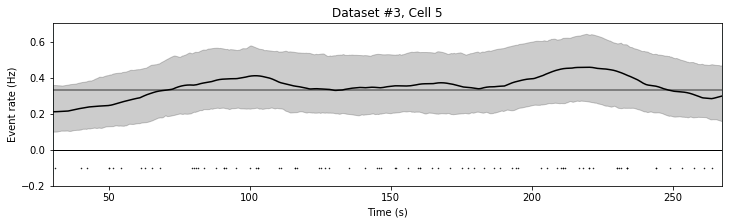

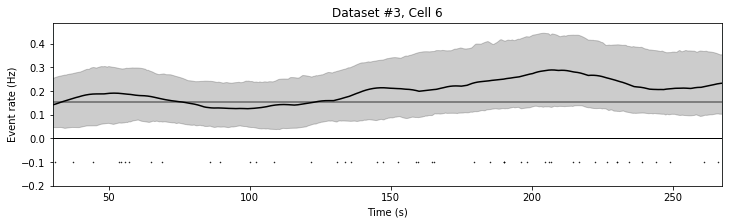

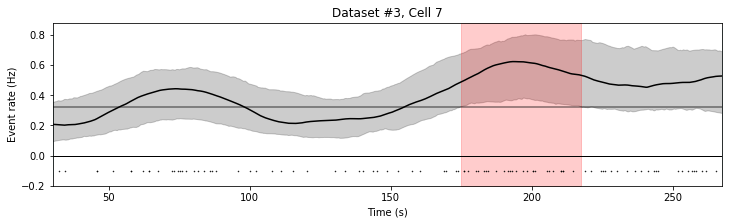

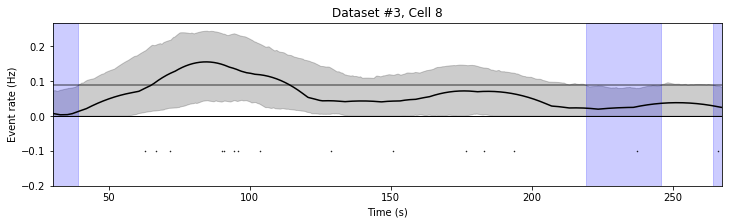

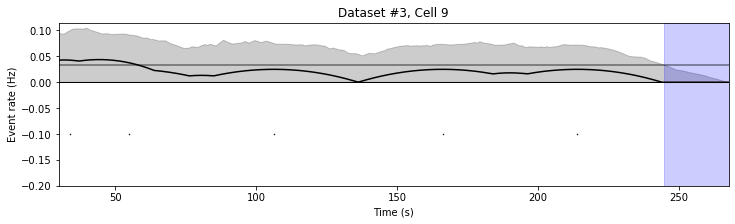

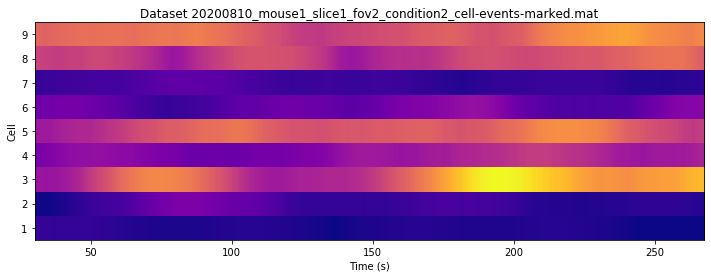

In [9]:
kernel_width = 30.
n_boot = 400

for i_dataset, dataset in manager.datasets.iterrows():
    
    print( f"Dataset: {dataset['filename']}" )
    
    header, events = manager.load_events( dataset )

    t_min = -kernel_width
    t_max = np.max( events['start_time'] ) + kernel_width
    t_eval = np.arange( t_min, t_max, 0.25 )

    n_cells = np.max( events['cell'] )
    n_t = t_eval.shape[0]
    rates = np.zeros( (n_cells, n_t) )
    for i_cell, cell in enumerate( range( 1, n_cells + 1 ) ):
        
        event_times = events[events['cell'] == cell]['start_time']
        rate_function = aqua.stats.RateFunctionKernel( kernel = ('epanechnikov', kernel_width) )
        rate_function.fit( event_times )
        r_hat, (r_hat_low, r_hat_high) = rate_function.predict( t_eval,
                                                                error = ('bootstrap', n_boot),
                                                                error_kind = ('ci', 0.05) )
        
        ## Print single cell rate estimate
        
        fig, ax = plt.subplots( figsize = (12, 3) )
#         ax = axs[0]
        plot_rate( ax, event_times, r_hat, t_eval, 
                   low = r_hat_low,
                   high = r_hat_high,
                   edge = 2 * kernel_width )
        ax.set_title( f"Dataset #{i_dataset}, Cell {i_cell + 1}" )
        
        rate_baseline = aqua.stats.RateFunctionConstant( window = (0. + kernel_width, 150. - kernel_width) )
        rate_baseline.fit( event_times )
#         r_baseline, (r_baseline_low, r_baseline_high) = rate_baseline.predict( t_eval,
#                                                                                error = ('bootstrap', 200),
#                                                                                error_kind = ('ci', 0.05),
#                                                                                error_kernel = ('epanechnikov', kernel_width) )
        
        ax.plot( t_eval, rate_baseline._rate * np.ones( t_eval.shape ), 'k-', alpha = 0.5 )
#         ax.fill_between( t_eval, r_baseline_high, r_baseline_low, color = 'k', alpha = 0.1 )
        
        yl = [-0.2, 1.1 * np.max( r_hat_high )]
        ax.fill_between( t_eval, yl[0], yl[1],
                          where = r_hat_low > rate_baseline._rate,
                          color = 'r',
                          alpha = 0.2  )
        ax.fill_between( t_eval, yl[0], yl[1],
                          where = r_hat_high < rate_baseline._rate,
                          color = 'b',
                          alpha = 0.2  )
        ax.set_ylim( yl )
        
        # Perform statistical comparison
#         p_compare = aqua.stats.compare_rates( rate_baseline,
#                                               rate_function,
#                                               t_eval,
#                                               400 )

#         ax = axs[1]

#         ax.plot( t_eval, p_compare, 'k-' )
#         ax.fill_between( t_eval, -0.05, 1.05,
#                           where = p_compare > 0.975,
#                           color = 'r',
#                           alpha = 0.2  )
#         ax.fill_between( t_eval, -0.05, 1.05,
#                           where = p_compare < 0.025,
#                           color = 'b',
#                           alpha = 0.2 )

#         ax.set_ylabel( 'p-value (> baseline)' )

#         xl = ax.get_xlim()
#         ax.plot( xl, 0.025 * np.array( [1, 1] ), 'k-', alpha = 0.3 )
#         ax.plot( xl, 0.975 * np.array( [1, 1] ), 'k-', alpha = 0.3 )

#         ax.set_ylim( -0.05, 1.05 )

#         ax.set_xlabel( 'Time (s)' )
        
        plt.show()

        rates[i_cell, :] = r_hat
    
    ## Print raster across cells
    
    plt.figure( figsize = (12, 4) )
    plt.imshow( rates,
                interpolation = 'none',
                aspect = 'auto',
                extent = [t_eval[0], t_eval[-1], 0.5, n_cells + 0.5] )

    plt.xlim( [t_eval[0] + 2 * kernel_width, t_eval[-1] - 2 * kernel_width] )
    
    plt.xlabel( 'Time (s)' )
    plt.ylabel( 'Cell' )
    
    plt.set_cmap( 'plasma' )
    plt.title( f"Dataset {dataset['filename']}" )
    plt.show()

In [10]:
events

,start_frame,start_time,cell,mark_area,mark_circMetric,mark_decayTau,mark_dffMax,mark_dffMax2,mark_fall91,mark_nOccurSameLoc,...,mark_propShrinkLeft_log,mark_propShrinkPosterior_log,mark_propShrinkRight_log,mark_rise19_log,mark_width11_log,mark_width55_log,mark_propGrowLateral,mark_propGrowMedial,mark_propShrinkLateral,mark_propShrinkMedial
0,328,230.79392,1,31.559103,3.865684,1.284929,1.251444,1.453575,3.51820,11.0,...,NaN,NaN,-0.572990,0.449411,0.801593,0.449411,0.089905,0.000000,0.000000,0.267307
1,12,8.44368,1,4.567765,0.725603,2.813213,1.285865,1.477139,6.33276,6.0,...,NaN,NaN,NaN,0.993479,1.209078,0.546321,0.000000,0.000000,0.000000,0.000000
2,308,216.72112,5,43.186141,3.188129,2.692007,4.373155,4.314166,4.92548,14.0,...,-1.179385,NaN,NaN,0.148381,0.801593,0.625502,0.000000,0.000000,0.066163,0.000000
3,59,41.51476,1,4.983016,0.984116,2.749034,0.926613,1.488926,5.62912,6.0,...,NaN,NaN,NaN,0.801593,1.077799,0.324472,0.000000,0.000000,0.000000,0.000000
4,172,121.02608,1,13.703295,2.021591,7.127611,0.883823,1.192761,15.48008,7.0,...,NaN,NaN,-0.005208,1.262324,1.528592,0.993479,0.000000,0.859200,0.000000,0.988080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,89,62.62396,8,7.059273,0.864276,0.238465,6.166556,5.454804,0.70364,1.0,...,NaN,NaN,NaN,-0.152649,0.148381,0.148381,0.000000,0.076714,0.000000,0.000000
558,160,112.58240,2,7.889776,1.514042,0.437996,8.813004,8.030525,2.11092,3.0,...,NaN,NaN,NaN,0.148381,0.546321,0.148381,0.000000,0.000000,0.000000,0.000000
559,165,116.10060,4,14.949049,1.574417,0.506117,3.298952,3.154374,1.40728,2.0,...,NaN,-1.257791,NaN,0.148381,0.449411,0.148381,0.000000,3.037886,0.000000,0.000000
560,388,273.01232,4,5.813519,1.528797,0.719088,11.328653,9.077250,2.81456,8.0,...,NaN,NaN,NaN,-0.152649,0.546321,0.324472,0.000000,0.000000,0.000000,0.000000


Plot comparisons between datasets

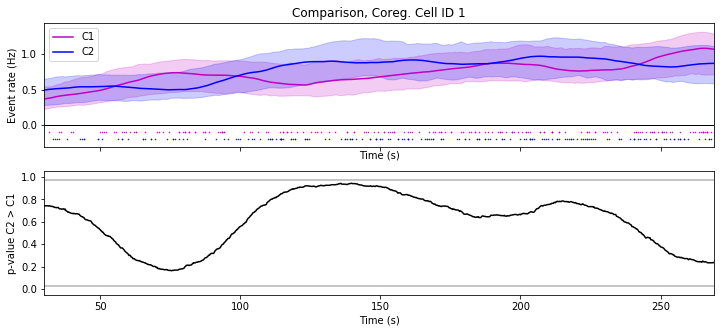

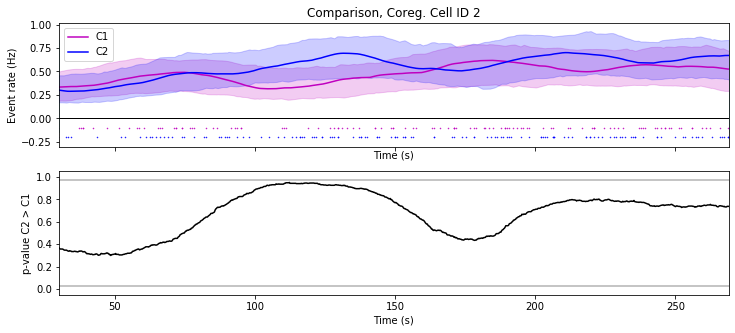

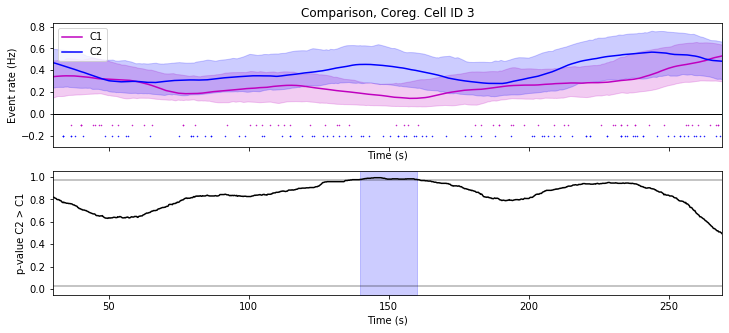

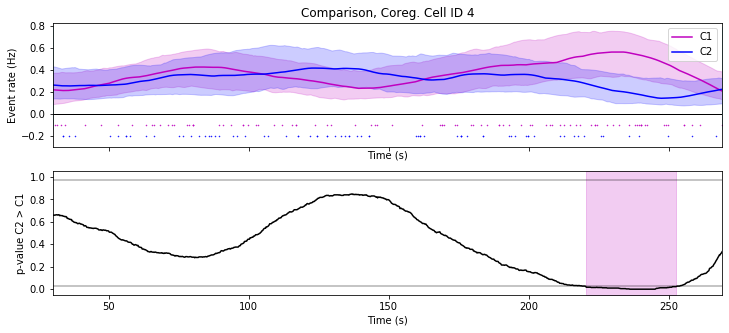

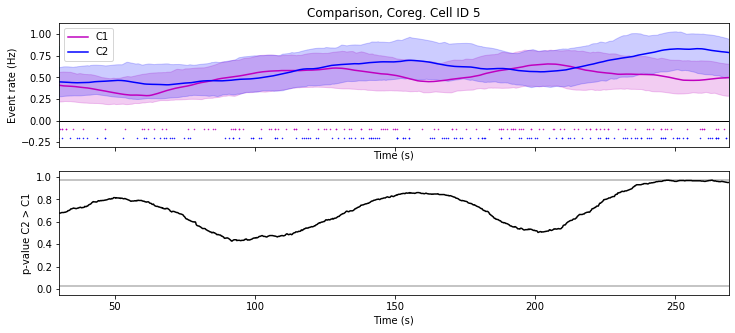

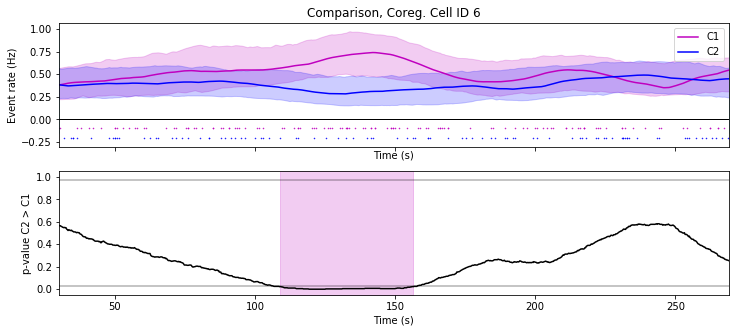

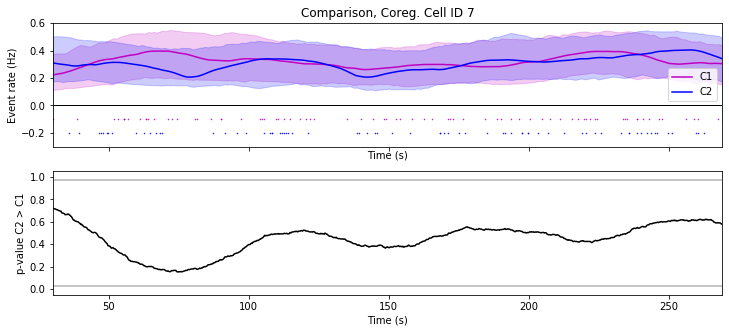

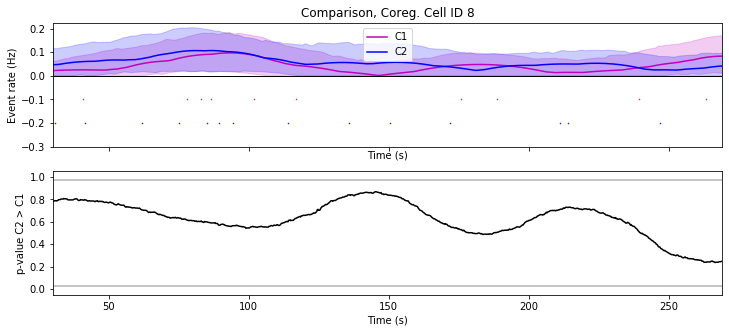

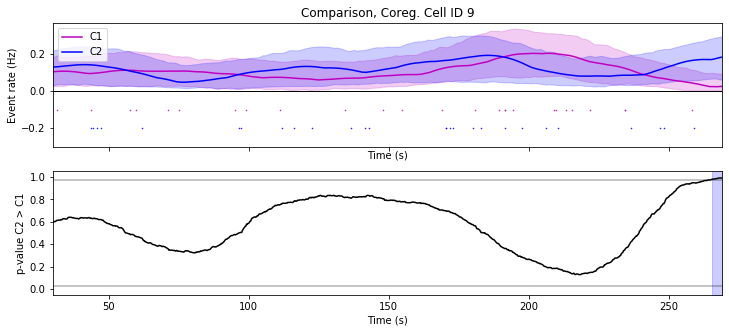

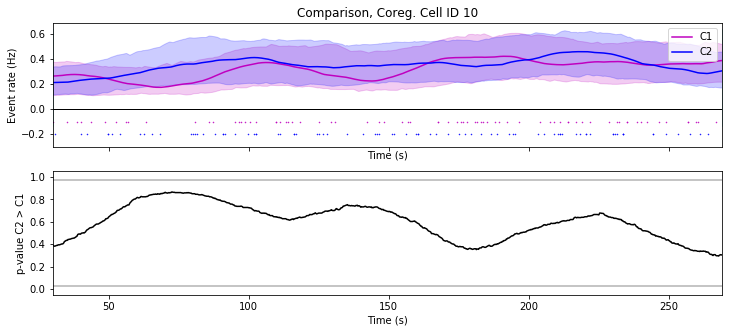

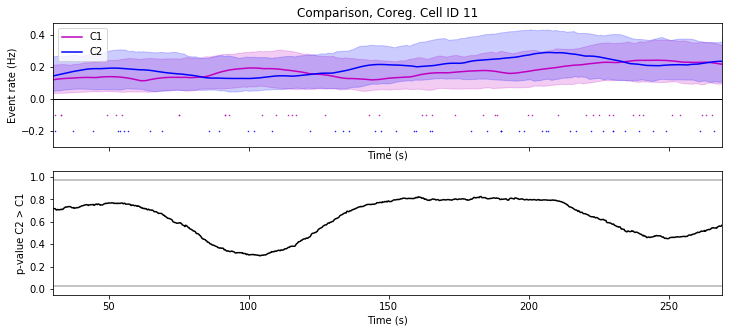

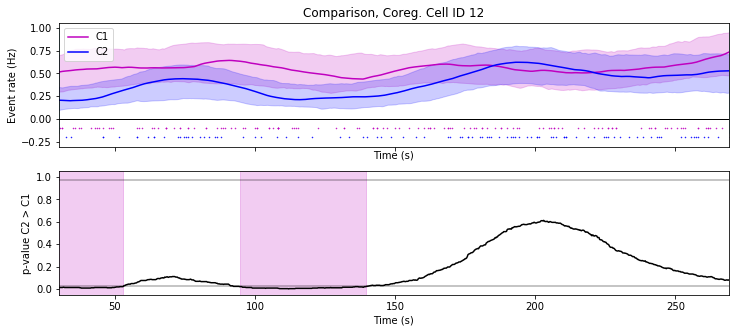

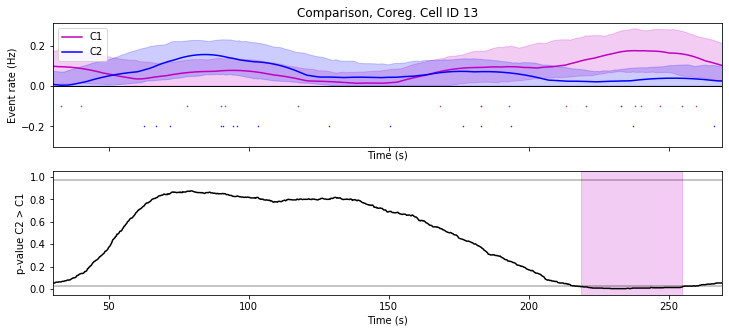

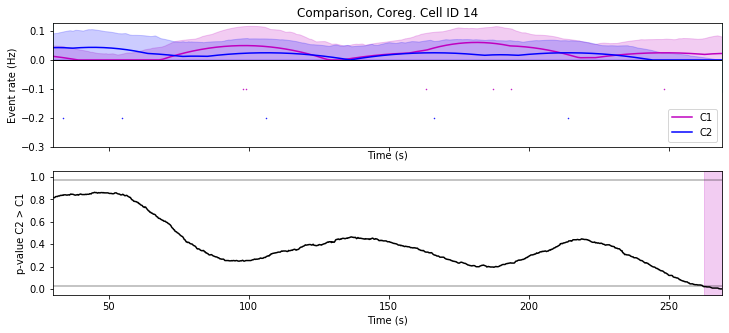

In [21]:
kernel_width = 30.

condition_colors = {
    'C1': 'm',
    'C2': 'b'
}

headers, all_events = manager.all_events()

t_min = -kernel_width
t_max = np.max( all_events['start_time'] ) + kernel_width
t_eval = np.arange( t_min, t_max, 0.25 )

n_cells = np.max( all_events['cell_coreg'] )
for i_cell, cell in enumerate( range( 1, n_cells + 1 ) ):
    
    condition_event_times = { cond: all_events[( (all_events['cell_coreg'] == cell)
                                                 & (all_events['condition'] == cond) )]['start_time']
                              for cond in condition_labels.values() }
    
    fig, axs = plt.subplots( 2, 1,
                             figsize = (12, 5),
                             sharex = True )
    
    condition_rate_functions = { cond: None
                                 for cond in condition_labels.values() }
    condition_r_hat_highs = { cond: None
                              for cond in condition_labels.values() }
    
    ax = axs[0]
    for i_condition, (condition, event_times) in enumerate( condition_event_times.items() ):
        rate_function = aqua.stats.RateFunctionKernel( kernel = ('epanechnikov', kernel_width) )
        rate_function.fit( event_times )
        r_hat, (r_hat_low, r_hat_high) = rate_function.predict( t_eval,
                                                                error = ('bootstrap', 200),
                                                                error_kind = ('ci', 0.05) )
        plot_rate( ax, event_times, r_hat, t_eval, 
                   low = r_hat_low,
                   high = r_hat_high,
                   edge = 2 * kernel_width,
                   color = condition_colors[condition],
                   label = condition,
                   y_events = (i_condition + 1) * (-0.1) )
        
        condition_rate_functions[condition] = rate_function
        condition_r_hat_highs[condition] = r_hat_high
    
    ax.set_title( f'Comparison, Coreg. Cell ID {i_cell + 1}' )
    y_max = 1.1 * np.max( [ np.max( vs ) for vs in condition_r_hat_highs.values() ] )
    ax.set_ylim( [-0.3, y_max] )
    ax.legend()
    
    # Perform statistical comparison
    p_compare = aqua.stats.compare_rates( condition_rate_functions['C1'],
                                          condition_rate_functions['C2'],
                                          t_eval,
                                          400 )
    
    ax = axs[1]
    
    ax.plot( t_eval, p_compare, 'k-' )
    ax.fill_between( t_eval, -0.05, 1.05,
                      where = p_compare > 0.975,
                      color = condition_colors['C2'],
                      alpha = 0.2  )
    ax.fill_between( t_eval, -0.05, 1.05,
                      where = p_compare < 0.025,
                      color = condition_colors['C1'],
                      alpha = 0.2 )
    
    ax.set_ylabel( 'p-value C2 > C1' )
    
    xl = ax.get_xlim()
    ax.plot( xl, 0.025 * np.array( [1, 1] ), 'k-', alpha = 0.3 )
    ax.plot( xl, 0.975 * np.array( [1, 1] ), 'k-', alpha = 0.3 )
    
    ax.set_ylim( -0.05, 1.05 )
    
    ax.set_xlabel( 'Time (s)' )
    
    plt.show()
#     print( p_compare )

Test cross-validation to determine kernel width

In [7]:
def rate_kernel_loo_loss( ts, idx_leave_out, kernel ):
    ts_arr = np.array( ts )
    
    loss = 0.
    for i_leave_out in idx_leave_out:
        ts_cur = np.delete( ts_arr, i_leave_out )
        t_leave_out = ts_arr[i_leave_out]
        
        rate_function = aqua.stats.RateFunctionKernel( kernel = kernel )
        rate_function.fit( ts_cur )
        cur_loss = -np.log( rate_function.predict( t_leave_out ) )
        loss += cur_loss
        
    return loss

In [8]:
from tqdm import tqdm

Across all cells simultaneously

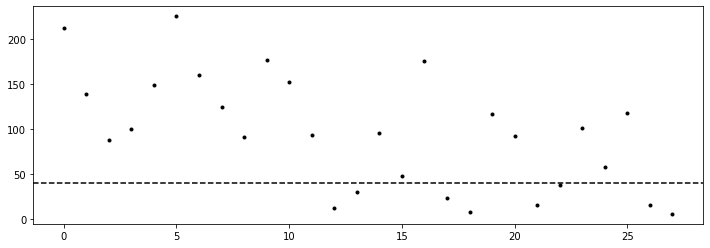

In [9]:
min_events = 40

headers, all_events = manager.all_events()
n_cells = np.max( all_events['cell_id'] )
cell_n_events = [ all_events[all_events['cell_id'] == cell].shape[0]
                  for cell in range( 1, n_cells + 1) ]

plt.figure( figsize = (12, 4) )
plt.plot( cell_n_events, 'k.' )
xl = plt.xlim()
plt.plot( xl, min_events * np.array( [1, 1] ), 'k--' )
plt.xlim( xl )
plt.show()

In [10]:
kernel_widths = np.arange( 15., 91., 1. )
max_kernel_width = np.max( kernel_widths )

headers, all_events = manager.all_events()
n_cells = np.max( all_events['cell_id'] )
cell_n_events = [ all_events[all_events['cell_id'] == cell].shape[0]
                  for cell in range( 1, n_cells + 1) ]
good_cells = [ cell
               for cell in range( 1, n_cells + 1 )
               if all_events[all_events['cell_id'] == cell].shape[0] >= min_events ]

cell_event_times = { cell: all_events[all_events['cell_id'] == cell]['start_time']
                     for cell in good_cells }
cell_t_max = { cell: np.max( ts )
               for cell, ts in cell_event_times.items() }

t_min = -max_kernel_width
t_max = np.min( list( cell_t_max.values() ) ) + max_kernel_width
t_eval = np.arange( t_min, t_max, 0.25 )

t_min_loglik = t_min + 2 * max_kernel_width
t_max_loglik = t_max - 2 * max_kernel_width

t_filter = ( (t_eval >= t_min_loglik)
             & (t_eval <= t_max_loglik) )
t_eval_filter = t_eval[t_filter]

loo_loss = np.zeros( kernel_widths.shape )
for i_width, kernel_width in tqdm( enumerate( kernel_widths ),
                                   total = len( kernel_widths ) ):
    
    cur_loss = 0.
    for cell, event_times in cell_event_times.items():
        event_filter = ( (event_times >= t_min_loglik)
                         & (event_times <= t_max_loglik) )
        idx_event_loo, = np.where( event_filter )
        cur_loss += rate_kernel_loo_loss( event_times, idx_event_loo,
                                          ('epanechnikov', kernel_width) )
    loo_loss[i_width] = cur_loss

100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


No local minima found


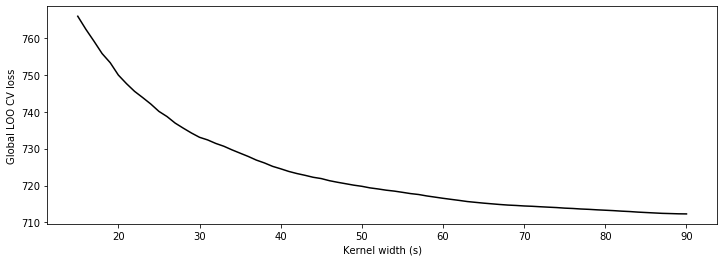

In [11]:
plt.figure( figsize = (12, 4) )

plt.plot( kernel_widths, loo_loss, 'k-' )
plt.ylabel( 'Global LOO CV loss' )
plt.xlabel( 'Kernel width (s)' )

local_min_candidates, = np.where( np.diff( loo_loss ) > 0 )
if len( local_min_candidates ) > 0:
    first_local_min = local_min_candidates[0]
    kernel_width_optimal = kernel_widths[first_local_min]
    yl = plt.ylim()
    plt.plot( kernel_width_optimal * np.array( [1, 1] ), yl, 'r--' )
    plt.ylim( yl )
else:
    print( 'No local minima found' )

plt.show()

For individual cells

In [12]:
import scipy.signal

  0%|          | 0/66 [00:00<?, ?it/s]

Cross-validating for 26 of 28 cells


100%|██████████| 66/66 [00:16<00:00,  3.98it/s]


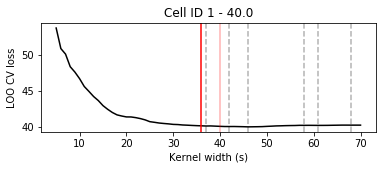

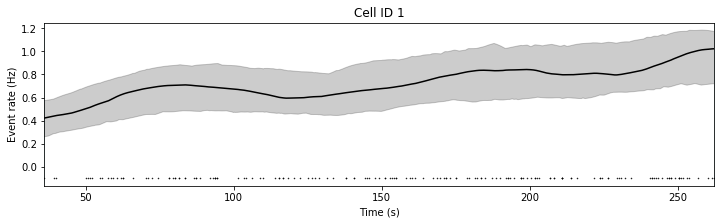

100%|██████████| 66/66 [00:07<00:00,  8.66it/s]


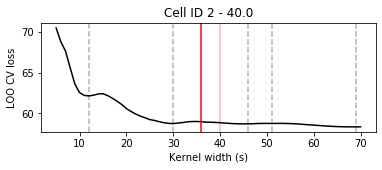

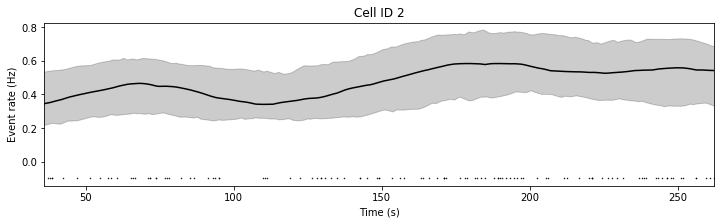

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:02<00:00, 26.84it/s]


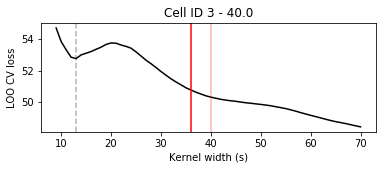

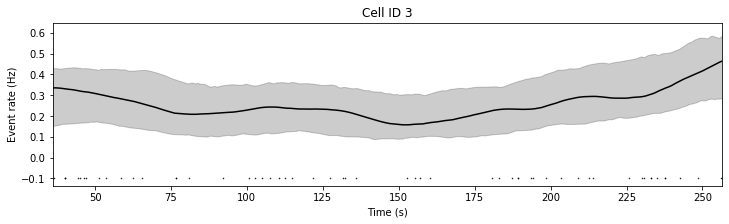

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:05<00:00, 11.79it/s]


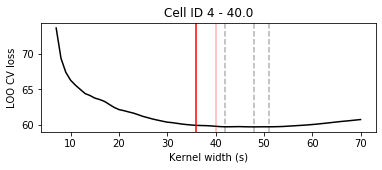

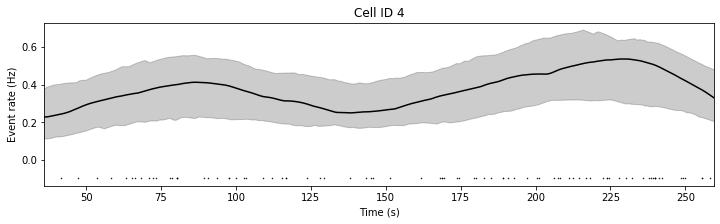

100%|██████████| 66/66 [00:12<00:00,  5.32it/s]


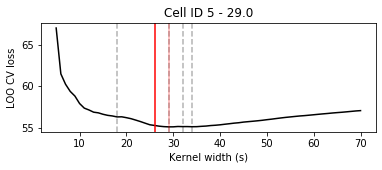

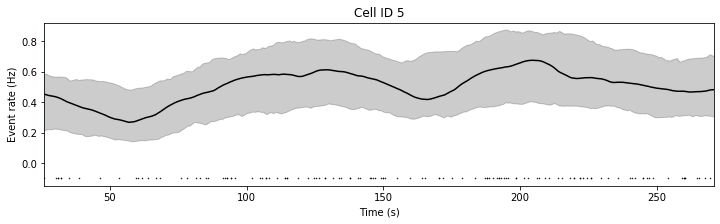

100%|██████████| 66/66 [00:36<00:00,  1.83it/s]


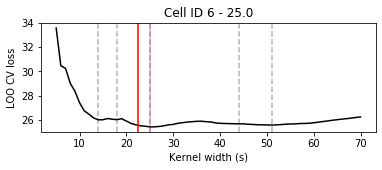

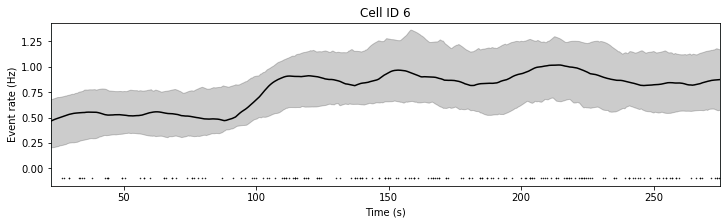

100%|██████████| 66/66 [00:12<00:00,  5.42it/s]


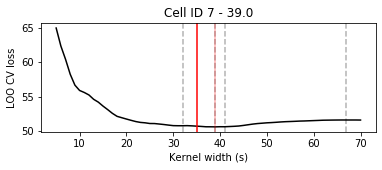

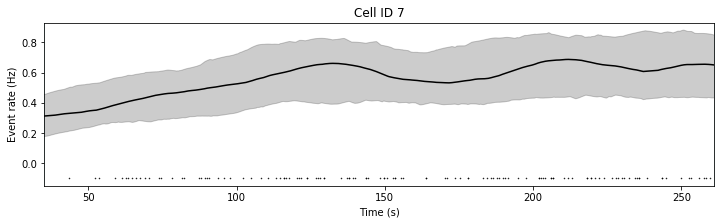

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:05<00:00, 11.73it/s]


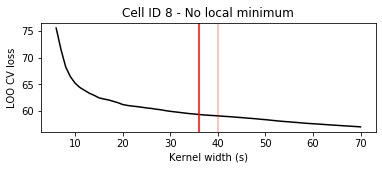

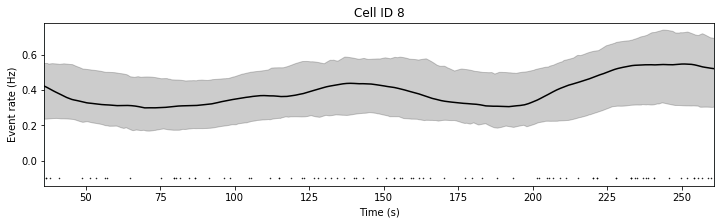

100%|██████████| 66/66 [00:04<00:00, 15.90it/s]


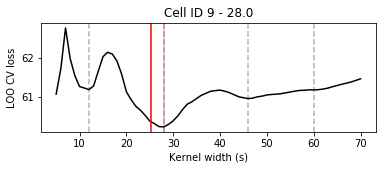

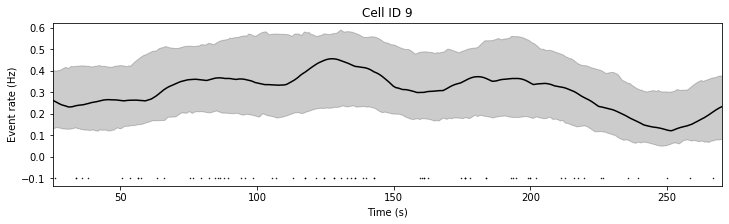

100%|██████████| 66/66 [00:12<00:00,  5.49it/s]


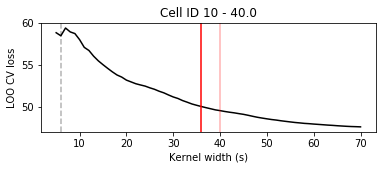

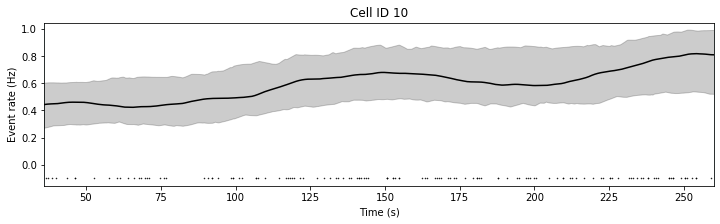

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:10<00:00,  6.50it/s]


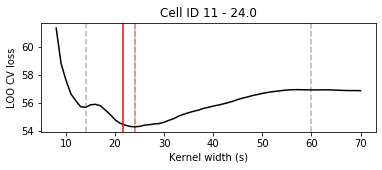

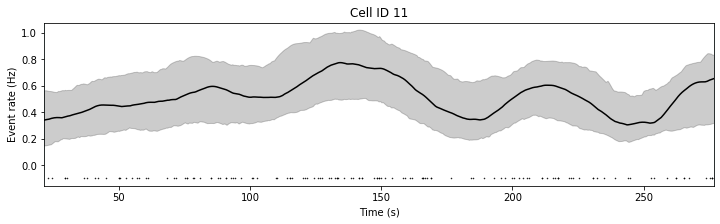

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:03<00:00, 17.71it/s]


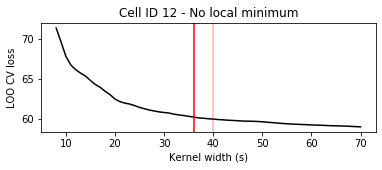

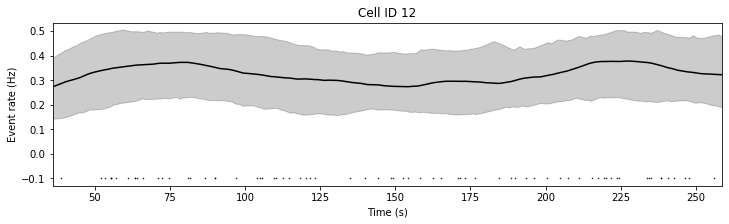

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 787.71it/s]


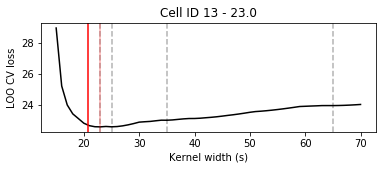

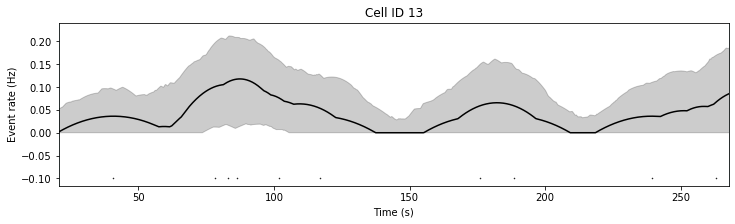

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 137.09it/s]


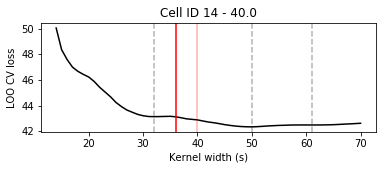

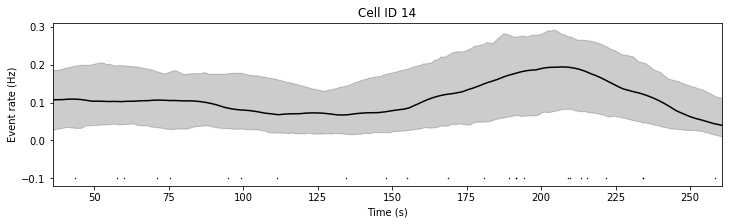

100%|██████████| 66/66 [00:03<00:00, 17.94it/s]


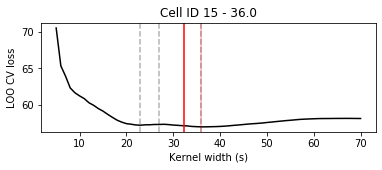

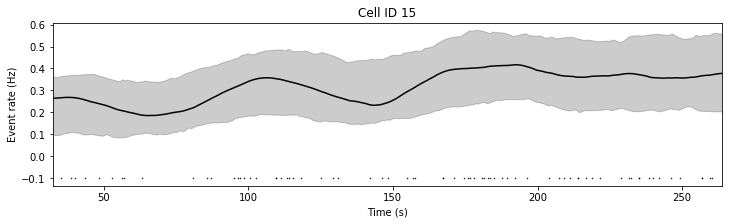

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 74.27it/s]


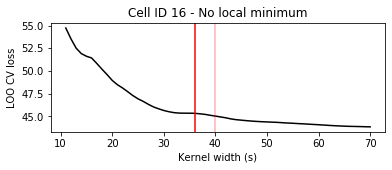

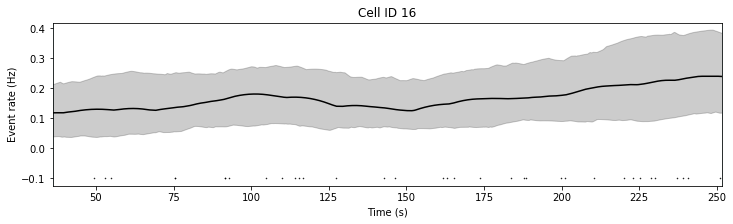

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:11<00:00,  5.91it/s]


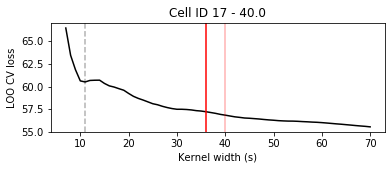

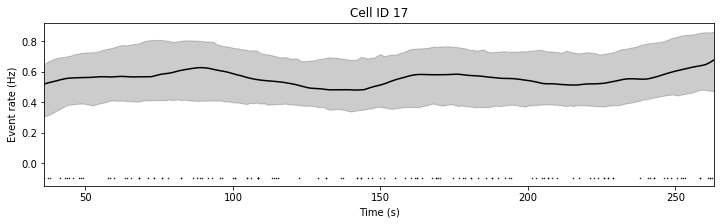

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 449.61it/s]


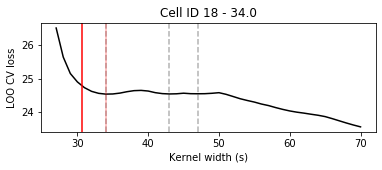

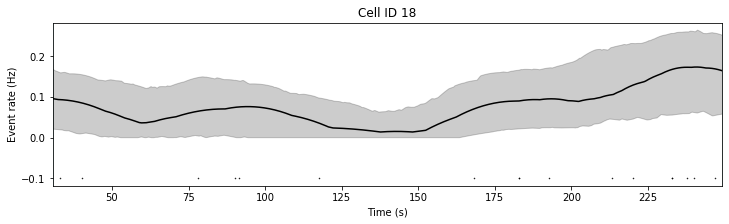

100%|██████████| 66/66 [00:04<00:00, 14.31it/s]


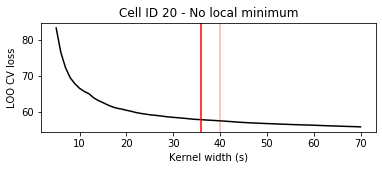

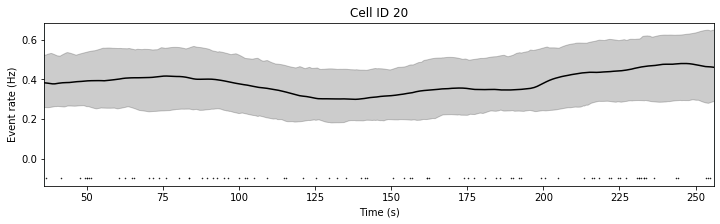

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:02<00:00, 25.66it/s]


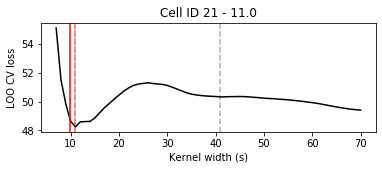

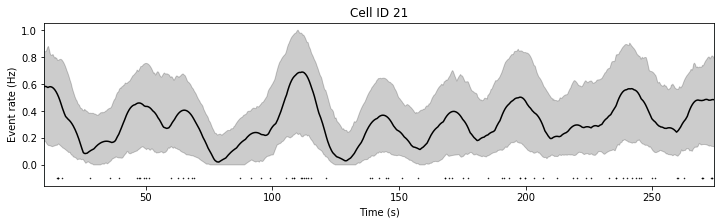

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 514.79it/s]


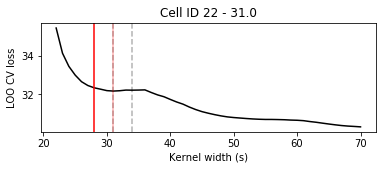

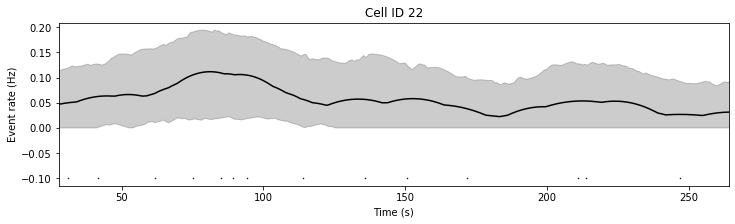

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 128.26it/s]


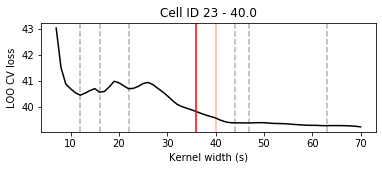

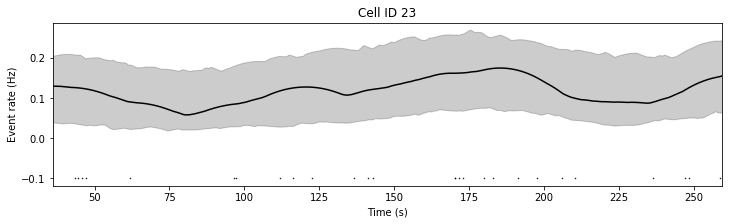

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:04<00:00, 15.74it/s]


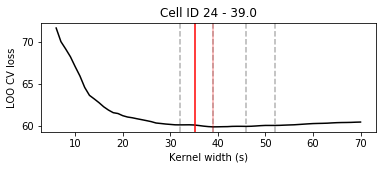

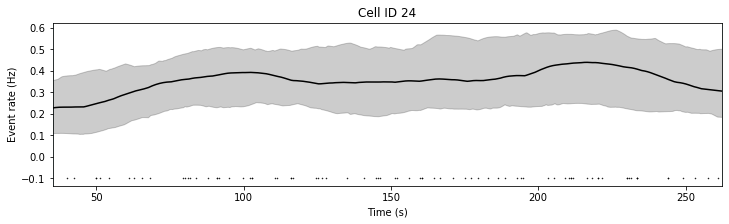

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:01<00:00, 58.09it/s]


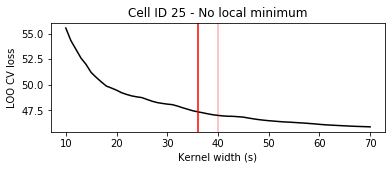

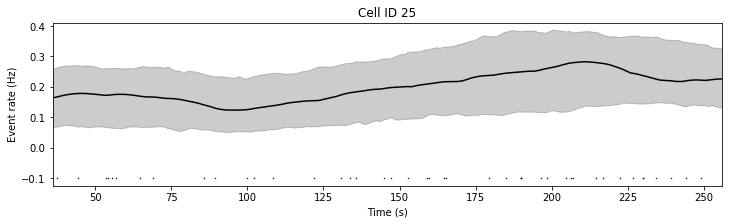

100%|██████████| 66/66 [00:05<00:00, 12.30it/s]


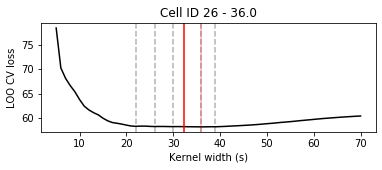

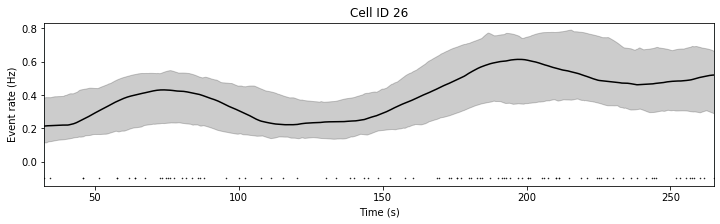

  0%|          | 0/66 [00:00<?, ?it/s]/Users/max/opt/anaconda3/envs/aqua-py/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 66/66 [00:00<00:00, 459.00it/s]


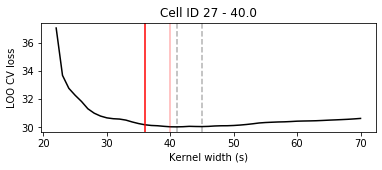

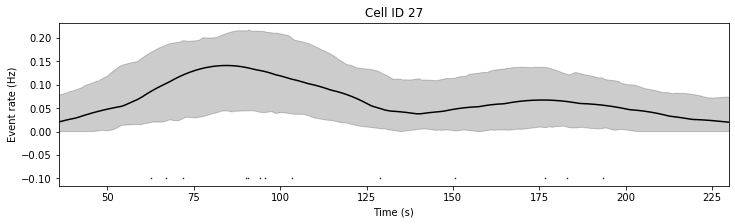

In [13]:
kernel_widths = np.arange( 5., 71., 1. )
max_kernel_width = np.max( kernel_widths )

undersmoothing = 0.9
kernel_width_override = 40.
override_loss_threshold = 1.

min_events = 10

headers, all_events = manager.all_events()
n_cells = np.max( all_events['cell_id'] )
cell_n_events = [ all_events[all_events['cell_id'] == cell].shape[0]
                  for cell in range( 1, n_cells + 1) ]
good_cells = [ cell
               for cell in range( 1, n_cells + 1 )
               if all_events[all_events['cell_id'] == cell].shape[0] >= min_events ]

print( f'Cross-validating for {len( good_cells )} of {n_cells} cells' )

cell_event_times = { cell: all_events[all_events['cell_id'] == cell]['start_time']
                     for cell in good_cells }
# cell_t_max = { cell: np.max( ts )
#                for cell, ts in cell_event_times.items() }

for cell, event_times in cell_event_times.items():
    t_min = -max_kernel_width
    t_max = np.max( event_times ) + max_kernel_width
    t_eval = np.arange( t_min, t_max, 0.25 )

    t_min_loglik = t_min + 2 * max_kernel_width
    t_max_loglik = t_max - 2 * max_kernel_width

    t_filter = ( (t_eval >= t_min_loglik)
                 & (t_eval <= t_max_loglik) )
    t_eval_filter = t_eval[t_filter]
    
    event_filter = ( (event_times >= t_min_loglik)
                     & (event_times <= t_max_loglik) )
    idx_event_loo, = np.where( event_filter )

    loo_loss = np.zeros( kernel_widths.shape )
    for i_width, kernel_width in tqdm( enumerate( kernel_widths ),
                                       total = len( kernel_widths ) ):
        loo_loss[i_width] = rate_kernel_loo_loss( event_times, idx_event_loo,
                                                  ('epanechnikov', kernel_width) )
    
    plt.figure( figsize = (6, 2) )

    plt.plot( kernel_widths, loo_loss, 'k-' )
    plt.ylabel( 'LOO CV loss' )
    plt.xlabel( 'Kernel width (s)' )
    
    local_minima, = scipy.signal.argrelextrema( loo_loss, np.less )
    kernel_width_optimal = kernel_width_override
    
    if len( local_minima ) > 0:
        for cur_min in local_minima:
            cur_kernel_width = kernel_widths[cur_min]
            yl = plt.ylim()
            plt.plot( cur_kernel_width * np.array( [1, 1] ), yl, 'k--', alpha = 0.3 )
            plt.ylim( yl )
        
        best_local_min = local_minima[np.argmin( loo_loss[local_minima] )]
        kernel_width_optimal = kernel_widths[best_local_min]
        
        i_override = np.argmin( np.abs( kernel_widths - kernel_width_override ) )
        loss_override = loo_loss[i_override]
        
        if loo_loss[best_local_min] - loss_override > override_loss_threshold:
            kernel_width_optimal = kernel_width_override
            
        if kernel_width_optimal > kernel_width_override:
            kernel_width_optimal = kernel_width_override
        
        plt.title( f'Cell ID {cell} - {kernel_width_optimal:0.1f}' )
    else:
        plt.title( f'Cell ID {cell} - No local minimum' )
    
    yl = plt.ylim()
    plt.plot( kernel_width_optimal * np.array( [1, 1] ), yl, 'r-', alpha = 0.3 )
    
    kernel_width_optimal = undersmoothing * kernel_width_optimal
    plt.plot( kernel_width_optimal * np.array( [1, 1] ), yl, 'r-' )
    plt.ylim( yl )
    
    plt.show()
    
    # Plot fit
    
    t_min_opti = -kernel_width_optimal
    t_max_opti = np.max( event_times ) + kernel_width_optimal
    t_eval_opti = np.arange( t_min_opti, t_max_opti, 0.25 )
    
    rate_function = aqua.stats.RateFunctionKernel( kernel = ('epanechnikov', kernel_width_optimal) )
    rate_function.fit( event_times )
    r_hat, (r_hat_low, r_hat_high) = rate_function.predict( t_eval_opti,
                                                            error = ('bootstrap', 200),
                                                            error_kind = ('ci', 0.05) )
    
    fig, ax = plt.subplots( figsize = (12, 3) )
    plot_rate( ax, event_times, r_hat, t_eval_opti, 
               low = r_hat_low,
               high = r_hat_high,
               edge = 2 * kernel_width_optimal )
    ax.set_title( f"Cell ID {cell}" )
    plt.show()